# Laboratorio 3
## Universidad del Valle de Guatemala <br> Facultas de Ingeniería
#### Departamento de Ciencias de la Computación <br> Deep Learning y Sistemas Inteligentes - Sección 20

In [13]:
# Importacion de librerias
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [14]:
# Leer data
data_frame = pd.read_csv('./data/monthly-sunspots.csv', usecols=[1], engine='python')
data_frame

,Sunspots
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0
...,...
2815,71.8
2816,50.3
2817,55.8
2818,33.3


### Implementar 3 redes neuronales con las siguientes estructuras para resolver el problema de regresión:

In [15]:

# ! Documentar los resultados

### 1. Feed Forward NN (Red Simple)

In [16]:
# Write code...

### 2. Recurrent Neural Network (RNN)

In [17]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(
        hidden_units
        , input_shape=input_shape
        , activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [18]:
def get_train_test(df, split_percent=0.8):
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)    
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

train_data, test_data, data = get_train_test(data_frame)

In [19]:
def get_XY(dat, time_steps):    
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]    
    rows_x = len(Y) # Preparar X
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [20]:
model = create_RNN(
    hidden_units=3
    , dense_units=1
    , input_shape=(time_steps,1)
    , activation=['tanh', 'tanh']
)
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 2s - loss: 0.0401 - 2s/epoch - 10ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0233 - 423ms/epoch - 2ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0182 - 460ms/epoch - 2ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0147 - 433ms/epoch - 2ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0124 - 416ms/epoch - 2ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0106 - 415ms/epoch - 2ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0094 - 418ms/epoch - 2ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0081 - 428ms/epoch - 2ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0072 - 395ms/epoch - 2ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0065 - 395ms/epoch - 2ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0057 - 406ms/epoch - 2ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0053 - 409ms/epoch - 2ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0050 - 391ms/epoch - 2ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0048 - 407ms/epoch - 2ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0046 - 404ms/epoch - 2ms/step
Epoch 16/20
187/187 - 0s - loss: 0.0

In [21]:
def print_error(trainY, testY, train_predict, test_predict):        
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))    
    # Imprimir los errores de predicciones
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 3ms/step
Train RMSE: 0.062 RMSE
Test RMSE: 0.084 RMSE


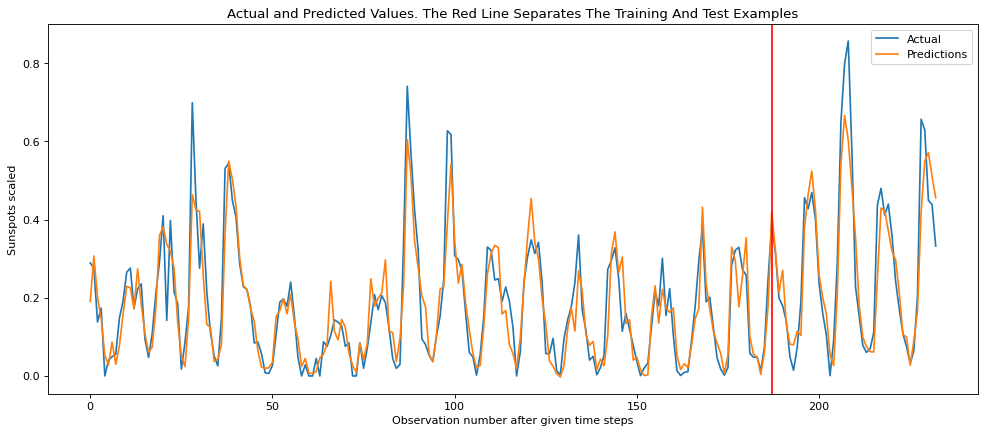

In [22]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    
plot_result(trainY, testY, train_predict, test_predict)

### 3. Long Short Term Memory (LSTM)

In [23]:
# Write code...

### Resultados

In [24]:

# ! Discutir pros y contras de utilizar cada arquitectura y justificar cual sería la elección para resolver este problema 
# ! basado en los resultados obtenidos y la teoría revisada en clase.